<a href="https://www.kaggle.com/code/aaradhyakulkarni/chapt-3-classification?scriptVersionId=208737824" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Setup

In [2]:
import sys

assert sys.version_info >= (3,7)

In [3]:
from packaging import version 
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
plt.rc('font',size = 14)
plt.rc('axes',labelsize=14,titlesize=16)
plt.rc('legend',fontsize=12)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [7]:
from sklearn.datasets import fetch_openml

In [8]:
mnist = fetch_openml(name = 'mnist_784', as_frame = False)
# we can also import as (data_id = 554)
# also to store it in desire path use (data_home = 'path')

mnist.keys()

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X,y = mnist.data, mnist.target

In [10]:
X.shape, y.shape

((70000, 784), (70000,))

In [11]:
def plot_digit(image_data,cmap = 'binary'):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap)
    plt.axis("off")

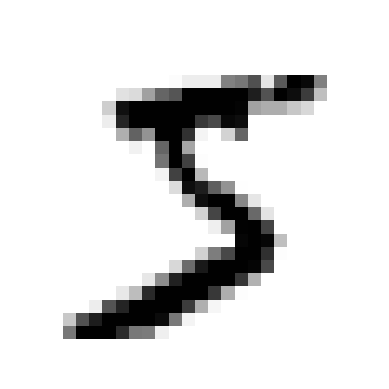

In [12]:
plot_digit(X[0])

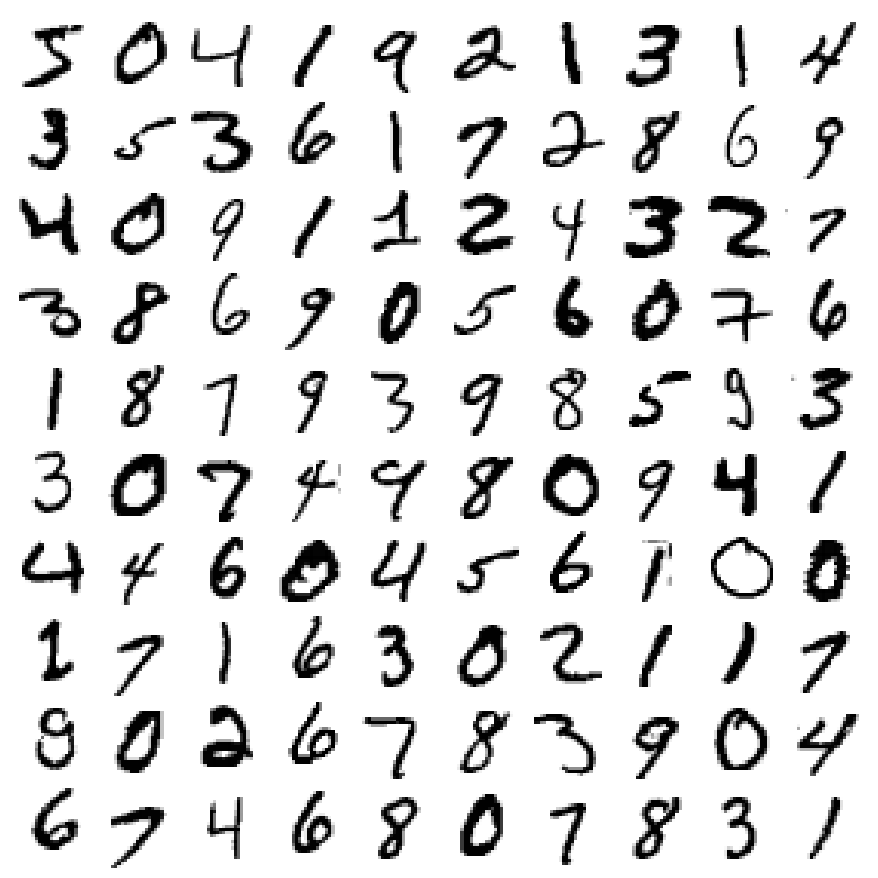

In [13]:
plt.figure(figsize=(9,9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10,10,idx+1)
    plot_digit(image_data)
plt.tight_layout()

plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)



# training a simple binary classifier

In [14]:
X_train , X_test , y_train, y_test  = X[:60000], X[60000:], y[:60000],y[60000:]

In [15]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [16]:
from sklearn.linear_model import SGDClassifier

In [17]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)
sgd_clf.predict([X[0]])

array([ True])

# Performance Measures

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [20]:
from sklearn.dummy import DummyClassifier

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [22]:
skfolds = StratifiedKFold(n_splits =3 )

for train_index ,test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))
    

0.95035
0.96035
0.9604


In [23]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [24]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

In [25]:
from sklearn.model_selection import cross_val_predict

In [56]:
y_train_predict = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [49]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score

In [57]:
y_train_predict

array([ True, False, False, ...,  True, False, False])

In [58]:
cm = confusion_matrix(y_train_5, y_train_predict)

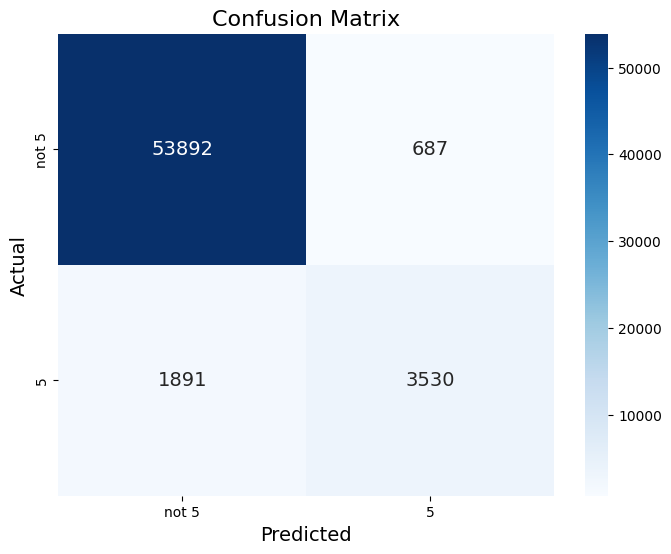

In [59]:
labels = ['not 5','5']
cm_df = pd.DataFrame(cm,index=labels,columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall Tradeoff

In [60]:
from sklearn.metrics import precision_recall_curve

In [61]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method='decision_function')

In [62]:
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

In [70]:
precisions.shape, recalls.shape, thresholds.shape

((60001,), (60001,), (60000,))

In [63]:

threshold = 3000

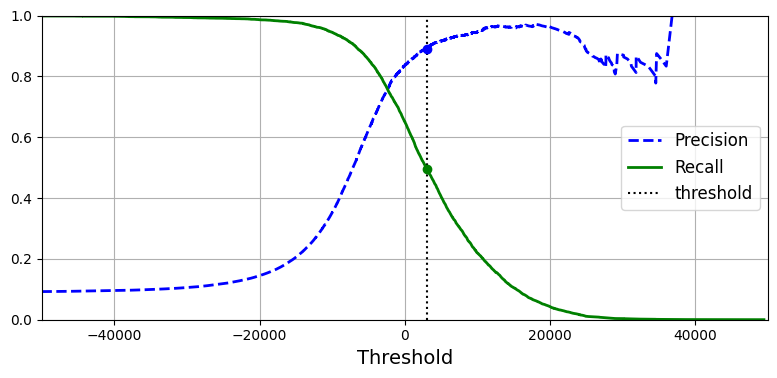

In [65]:
plt.figure(figsize=(8, 4))  # extra code – it's not needed, just formatting
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

In [83]:
idx

56978

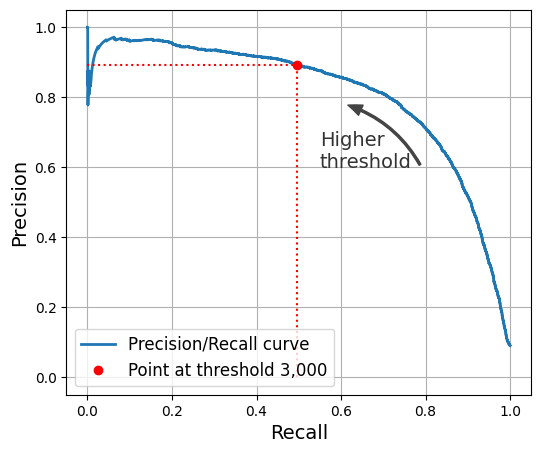

In [97]:
import matplotlib.patches as patches  
plt.figure(figsize=(6, 5))  

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "r:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "r:")
plt.plot([recalls[idx]], [precisions[idx]], "ro",
         label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.55, 0.6, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend(loc="lower left")

plt.show()

In [107]:
idx_for_90_precision = (precisions>0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [109]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [110]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [111]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC Curve

In [112]:
from sklearn.metrics import roc_curve

In [113]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

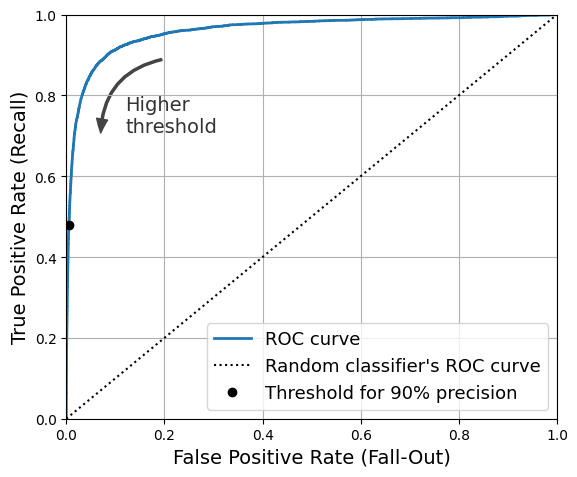

In [115]:

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5)) 
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [117]:
from sklearn.metrics import roc_auc_score

In [118]:
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

## Comparison :  RandomForestClassifier vs SGDClassifier

In [119]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [120]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [121]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [122]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

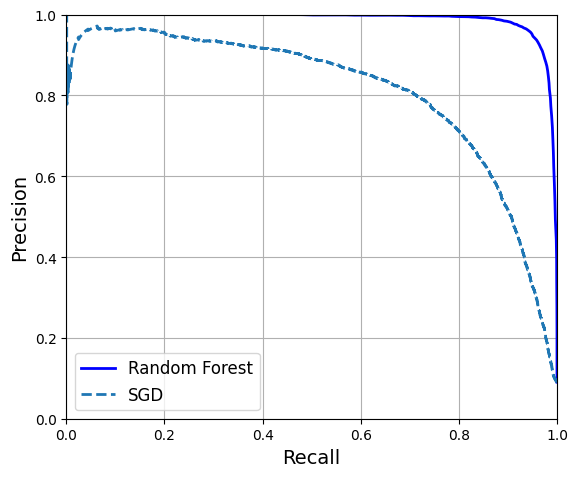

In [123]:
plt.figure(figsize=(6, 5)) 

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [124]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [126]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5

In [127]:
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [129]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

In [130]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485